In [1]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
co = pymysql.connect(host='132.248.3.66', db='3MdB', 
                     user='OVN_user', passwd='oiii5007') 

In [83]:
res = pd.read_sql("""SELECT 
OXYGEN as O,
NITROGEN as N,
logU_mean,
Hbfrac,
atm1 as teff,
lumi,
dens,
HE_2__4686A / H__1__4861A as HeII,
TOTL__7325A/O__3__5007A as RO,
(S_II__6731A+S_II__6716A)/S__3__6312A as RS,
TOTL__4363A/O__3__5007A as RO3,
N__2__5755A/N__2__6584A as RN2,
O__3__5007A/H__1__4861A as O3,
N__2__6584A/H__1__4861A as N2
FROM tab 
WHERE ref like 'PNe_2014' 
AND abs(HE_2__4686A/H__1__4861A - 0.7) / 0.7 < 0.3
AND abs(TOTL__7325A/O__3__5007A - 0.0095) / 0.0095 < 0.3 
AND abs((S_II__6731A+S_II__6716A)/S__3__6312A - 15 ) / 15 < 0.3
AND abs(N__2__5755A/N__2__6584A - 0.019) / 0.019 < 0.3
AND abs(O__3__5007A/H__1__4861A - 8.5) / 8.5 < 0.3
AND abs(N__2__6584A/H__1__4861A - 4.5) / 4.5 < 0.3
""", 
con=co)
#AND abs(TOTL__4363A/O__3__5007A - 0.033) / 0.033 < 0.5


In [84]:
len(res)

293

In [92]:
def khi2(label, obs, sigma=0.15):
    return ((res[label] - obs)/obs/sigma)**2

khi2_tot =        ((khi2('HeII', 0.7) + 
                    khi2('RO', 8/850.) +
                    khi2('RS', 15) +
#                    khi2('RO3', 28/850) +
                    khi2('RN2', 0.019) +
                    khi2('O3', 8.5) +
                    khi2('N2', 4.5))/6)
res['khi2'] = khi2_tot
res=res.sort_values('khi2')
print(res[0:30])

        O     N  logU_mean  Hbfrac      teff     lumi      dens      HeII  \
288 -3.36 -3.75   -2.48161     1.0  300000.0  4.00000  0.000000  0.742350   
154 -3.36 -3.75   -2.48319     1.0  300000.0  4.00000  0.000000  0.742375   
218 -3.36 -3.75   -2.48775     1.0  300000.0  4.00000  0.000000  0.742437   
162 -3.36 -3.75   -2.88038     1.0  180000.0  3.00000  0.000000  0.677634   
74  -3.36 -3.75   -2.50433     1.0  300000.0  4.00000  0.000000  0.742662   
289 -3.36 -3.75   -2.48229     1.0  300000.0  4.00000  0.000000  0.744905   
155 -3.36 -3.75   -2.48391     1.0  300000.0  4.00000  0.000000  0.744903   
219 -3.36 -3.75   -2.48848     1.0  300000.0  4.00000  0.000000  0.745068   
192 -3.36 -3.75   -2.49869     1.0  210000.0  4.00000  2.000000  0.693211   
291 -3.36 -3.75   -2.86524     1.0  180000.0  3.00000  0.000000  0.680673   
27  -3.36 -3.75   -2.95050     1.0  180000.0  2.30103  2.000000  0.644689   
181 -3.36 -3.75   -2.53094     1.0  210000.0  4.00000  2.000000  0.689914   

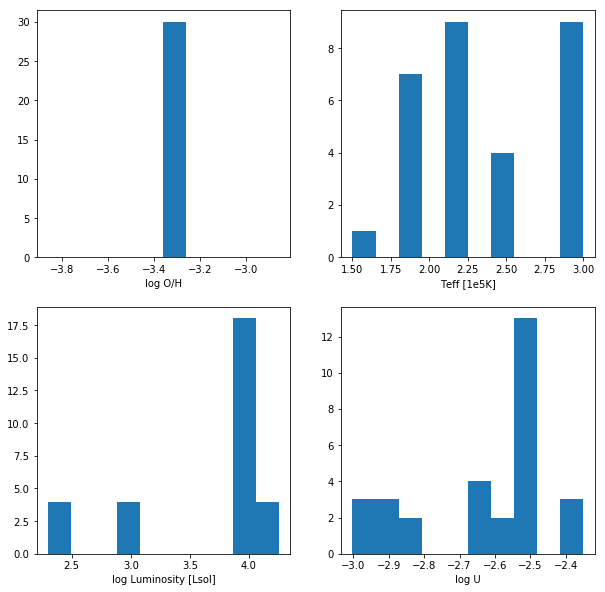

In [96]:
res2 = res[0:30]
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
ax1.hist(res2['O'])
ax1.set_xlabel('log O/H')
ax2.hist(res2['teff']/1e5)
ax2.set_xlabel('Teff [1e5K]')
ax3.hist(res2['lumi'])
ax3.set_xlabel('log Luminosity [Lsol]')
ax4.hist(res2['logU_mean'])
ax4.set_xlabel('log U');